# Triplet Loss for Implicit Feedback Neural Recommender Systems

The goal of this notebook is first to demonstrate how it is possible to build a bi-linear recommender system only using positive feedback data.

In a latter section we show that it is possible to train deeper architectures following the same design principles.

This notebook is a custom version of https://github.com/m2dsupsdlclass/lectures-labs/blob/master/labs/03_neural_recsys/Implicit_Feedback_Recsys_with_the_triplet_loss_rendered.ipynb

## Loading the movielens-100k dataset

For the sake of computation time, we will only use the smallest variant of the movielens reviews dataset. Beware that the architectural choices and hyperparameters that work well on such a toy dataset will not necessarily be representative of the behavior when run on a more realistic dataset such as [Movielens 10M](https://grouplens.org/datasets/movielens/10m/) or the [Yahoo Songs dataset with 700M rating](https://webscope.sandbox.yahoo.com/catalog.php?datatype=r).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve


ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = ML_100K_URL.rsplit('/', 1)[1]
ML_100K_FOLDER = 'ml-100k'

if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall('.')

In [2]:
data_train = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.base'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])
data_test = pd.read_csv(op.join(ML_100K_FOLDER, 'ua.test'), sep='\t',
                        names=["user_id", "item_id", "rating", "timestamp"])

data_train.describe()

,user_id,item_id,rating,timestamp
count,90570.000000,90570.000000,90570.000000,9.057000e+04
mean,461.494038,428.104891,3.523827,8.835073e+08
std,266.004364,333.088029,1.126073,5.341684e+06
min,1.000000,1.000000,1.000000,8.747247e+08
25%,256.000000,174.000000,3.000000,8.794484e+08
50%,442.000000,324.000000,4.000000,8.828143e+08
75%,682.000000,636.000000,4.000000,8.882049e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


In [3]:
def extract_year(release_date):
    if hasattr(release_date, 'split'):
        components = release_date.split('-')
        if len(components) == 3:
            return int(components[2])
    # Missing value marker
    return 1920


m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|',
                    names=m_cols, usecols=range(5), encoding='latin-1')
items['release_year'] = items['release_date'].map(extract_year)

data_train = pd.merge(data_train, items)
data_test = pd.merge(data_test, items)

In [4]:
data_train.head()

,user_id,item_id,rating,timestamp,title,release_date,video_release_date,imdb_url,release_year
0,1,1,5,874965758,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,1,4,888550871,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
2,6,1,4,883599478,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
3,10,1,4,877888877,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
4,13,1,3,882140487,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995


In [5]:
max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())

n_users = max_user_id + 1 #Why add 1 ??
n_items = max_item_id + 1


print('n_users=%d, n_items=%d' % (n_users, n_items))

n_users=944, n_items=1683


## Implicit feedback data

Consider ratings >= 4 as positive feed back and ignore the rest:

In [6]:
pos_data_train = data_train[data_train["rating"] >= 4]
pos_data_test = data_test[data_test["rating"] >= 4]

In [7]:
pos_data_train.head()

,user_id,item_id,rating,timestamp,title,release_date,video_release_date,imdb_url,release_year
0,1,1,5,874965758,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
1,2,1,4,888550871,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
2,6,1,4,883599478,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
3,10,1,4,877888877,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995
6,16,1,5,877717833,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995


Because the median rating is around 3.5, this cut will remove approximately half of the ratings from the datasets. What is the size of the (train/test) set?

In [8]:
len(pos_data_train), len(data_train)

(49906, 90570)

## The Triplet Loss

The following section demonstrates how to build a low-rank quadratic interaction model between users and items. The similarity score between a user and an item is defined by the unormalized dot products of their respective embeddings.

The matching scores can be use to rank items to recommend to a specific user.

Training of the model parameters is achieved by randomly sampling negative items not seen by a pre-selected anchor user. We want the model embedding matrices to be such that the similarity between the user vector and the negative vector is smaller than the similarity between the user vector and the positive item vector. Furthermore we use a margin to further move appart the negative from the anchor user.

Here is the architecture of such a triplet architecture. The triplet name comes from the fact that the loss to optimize is defined for triple `(anchor_user, positive_item, negative_item)`:

<img src="https://bianchi.wp.imt.fr/files/2019/01/rec_archi_implicit_2.jpg" style="width: 600px;" />

We call this model a triplet model with bi-linear interactions because the similarity between a user and an item is captured by a dot product of the first level embedding vectors. This is therefore not a deep architecture.

In [9]:
import tensorflow as tf

def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred
    
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return tf.reduce_mean(y_pred + 0 * y_true)


def margin_comparator_loss(inputs, margin=1.):
    """Comparator loss for a pair of precomputed similarities
    
    If the inputs are cosine similarities, they each have range in
    (-1, 1), therefore their difference have range in (-2, 2). Using
    a margin of 1. can therefore make sense.

    If the input similarities are not normalized, it can be beneficial
    to use larger values for the margin of the comparator loss.
    """
    positive_pair_sim, negative_pair_sim = inputs
    return tf.maximum(negative_pair_sim - positive_pair_sim + margin, 0)

Here is the actual code that builds the model(s) with shared weights. Note that here we use the cosine similarity instead of unormalized dot products (both seems to yield comparable results).

In [10]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dense
from keras.layers import Lambda, Dot
from keras.regularizers import l2
from keras.layers.merge import dot, concatenate


def build_models(n_users, n_items, latent_dim=64, l2_reg=0):
    """Build a triplet model and its companion similarity model
    
    The triplet model is used to train the weights of the companion
    similarity model. The triplet model takes 1 user, 1 positive item
    (relative to the selected user) and one negative item and is
    trained with comparator loss.
    
    The similarity model takes one user and one item as input and return
    compatibility score (aka the match score).
    """
    # Common architectural components for the two models:
    # - symbolic input placeholders
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')

    # - embeddings
    l2_reg = None if l2_reg == 0 else l2(l2_reg)
    user_layer = Embedding(input_dim=n_users, output_dim=latent_dim, input_length=1,
                           name='user_embedding', embeddings_regularizer=l2_reg)
    
    # The following embedding parameters will be shared to encode both
    # the positive and negative items.
    item_layer = Embedding(input_dim=n_items, output_dim=latent_dim, input_length=1,
                           name="item_embedding", embeddings_regularizer=l2_reg)

    user_embedding = Flatten()(user_layer(user_input))
    positive_item_embedding = Flatten()(item_layer(positive_item_input))
    negative_item_embedding = Flatten()(item_layer(negative_item_input))

    # - similarity computation between embeddings
    positive_similarity = Dot(name="positive_similarity",
                              axes=1, normalize=True)(
        [user_embedding, positive_item_embedding])
    negative_similarity = Dot(name="negative_similarity",
                              axes=1, normalize=True)(
        [user_embedding, negative_item_embedding])

    # The triplet network model, only used for training
    triplet_loss = Lambda(margin_comparator_loss,
                          name='comparator_loss',
                          output_shape=(1,))([positive_similarity, negative_similarity])

    triplet_model = Model(inputs=[user_input,
                                  positive_item_input,
                                  negative_item_input],
                          outputs=triplet_loss)
    
    # The match-score model, only use at inference to rank items for a given
    # model: the model weights are shared with the triplet_model therefore
    # we do not need to train it and therefore we do not need to plug a loss
    # and an optimizer.
    match_model = Model(inputs=[user_input, positive_item_input],
                        outputs=positive_similarity)
    
    return triplet_model, match_model


triplet_model, match_model = build_models(n_users, n_items, latent_dim=64,
                                          l2_reg=1e-6)

Using TensorFlow backend.


### Exercise:

Represent both models as a graph.

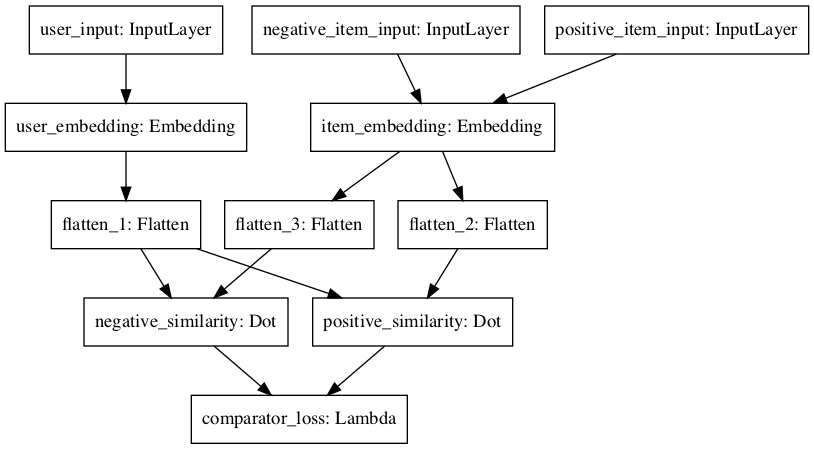

In [11]:
from keras.utils import plot_model
plot_model(triplet_model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png')

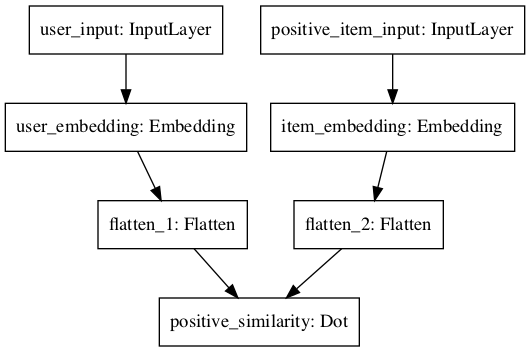

In [12]:
from keras.utils import plot_model
plot_model(match_model, to_file='model.png')
from IPython.display import Image
Image(filename='model.png')

### Exercise

How many trainable parameters does each model. Count the shared parameters only once per model.

In [13]:
triplet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
positive_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
negative_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        60416       user_input[0][0]                 
__________________________________________________________________________________________________
item_embed

In [14]:
match_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
positive_item_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 64)        60416       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 64)        107712      positive_item_input[0][0]        
__________________________________________________________________________________________________
flatten_1 

## Quality of Ranked Recommendations

Now that we have a randomly initialized model we can start computing random recommendations. To assess their quality we do the following for each user:

- compute matching scores for items (except the movies that the user has already seen in the training set),
- compare to the positive feedback actually collected on the test set using the ROC AUC ranking metric,
- average ROC AUC scores across users to get the average performance of the recommender model on the test set.

#### Preliminary exercise
Set user_id = 1. Compute the list of item_id's that user 1 has positively rated, as observed from the training set

In [15]:
user_id = 1
pos_item_train = pos_data_train[pos_data_train['user_id'] == user_id]['item_id'].values
pos_item_train

array([  1,   3,   6,   7,   9,  12,  13,  14,  15,  16,  18,  19,  22,
        23,  25,  28,  32,  39,  42,  43,  44,  45,  46,  47,  48,  50,
        51,  52,  55,  56,  57,  58,  59,  60,  64,  65,  66,  68,  72,
        75,  76,  77,  79,  80,  81,  82,  84,  86,  87,  88,  89,  90,
        91,  93,  95,  96,  98, 100, 106, 107, 108, 109, 111, 113, 114,
       115, 119, 121, 123, 124, 127, 128, 129, 132, 133, 134, 135, 137,
       144, 146, 150, 151, 152, 154, 156, 157, 161, 162, 163, 165, 166,
       168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 181, 182, 183,
       184, 185, 186, 187, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 203, 204, 206, 207, 208, 209, 210, 212, 214, 216, 221, 222,
       223, 224, 227, 228, 229, 230, 234, 235, 236, 238, 239, 241, 242,
       246, 248, 249, 250, 251, 253, 256, 257, 258, 267, 268, 269, 270])

Compute the list of the OTHER (unrated) items. These are the interesting items : either unseen or disliked.

In [16]:
all_item_ids = np.arange(1, max_item_id + 1)
items_to_rank = np.setdiff1d(all_item_ids, pos_item_train)
items_to_rank

array([   2,    4,    5, ..., 1680, 1681, 1682])

Compute the predicted score of user 1 for each item. The items with largest scores are supposed to be the ones that would be positively rated.

In [17]:
repeated_user_id = np.empty_like(items_to_rank)
repeated_user_id.fill(user_id)

predicted = match_model.predict([repeated_user_id, items_to_rank])
predicted

array([[-0.00664061],
       [-0.13620281],
       [-0.03182816],
       ...,
       [ 0.06303412],
       [ 0.254694  ],
       [-0.02479743]], dtype=float32)

Now we compare with the test set. Compute the list of items that user 1 has positively rated, as observed from the test set.

In [18]:
pos_item_test = pos_data_test[pos_data_test['user_id'] == user_id]['item_id'].values
pos_item_test

array([ 20,  33,  61, 160, 171, 202, 265])

Compute the ground truth i.e., a vector of length len(items_to_rank) having a "1" if the item is positivilely rated in the test set, "0" otherwise.

n.b.: np.in1d = Test whether each element of a 1-D array is also present in a second array

In [19]:
expected = np.in1d(items_to_rank, pos_item_test)
expected

array([False, False, False, ..., False, False, False])

By thresholding the predicted scores
$$
\text{score}_{u,i} \lessgtr \gamma\,,
$$
one would predict whether a given unrated item would positively rated. Letting the threshold $\gamma$ vary, one can compute the area under the ROC curve. To this end, compare with the ground truth.

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(expected, predicted)

0.6357566067901815

This ROC AUC is a measure of how well the model helps to predict the positive items for user 1. 
Doing the same thing for all users and averaging the ROC AUC over all user yields the final performance evaluation of the model. We encode this in a single function.

In [21]:
def average_roc_auc(match_model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users"""
    max_user_id = max(data_train['user_id'].max(), data_test['user_id'].max())
    max_item_id = max(data_train['item_id'].max(), data_test['item_id'].max())
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['user_id'] == user_id]
        pos_item_test = data_test[data_test['user_id'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_ids = np.arange(1, max_item_id + 1)
        items_to_rank = np.setdiff1d(all_item_ids, pos_item_train['item_id'].values)
        
        # Ground truth: return 1 for each item positively present in the test set
        # and 0 otherwise.
        expected = np.in1d(items_to_rank, pos_item_test['item_id'].values)
        
        if np.sum(expected) >= 1:
            # At least one positive test value to rank
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)

            predicted = match_model.predict([repeated_user_id, items_to_rank],
                                            batch_size=4096)
            user_auc_scores.append(roc_auc_score(expected, predicted))

    return sum(user_auc_scores) / len(user_auc_scores)

By default the model should make predictions that rank the items in random order. The **ROC AUC score** is a ranking score that represents the **expected value of correctly ordering uniformly sampled pairs of recommendations**.

Compute the average roc auc for the current model. Discuss the result.

## Training the Triplet Model

Let's now fit the parameters of the model by sampling triplets: for each user, select a movie in the positive feedback set of that user and randomly sample another movie to serve as negative item.

Note that this sampling scheme could be improved by removing items that are marked as positive in the data to remove some label noise. In practice this does not seem to be a problem though.

Discuss the outcome of the following function. What is its purpose? Try applying it on pos_data_train.

In [22]:
def sample_triplets(pos_data, max_item_id, random_seed=0):
    """Sample negatives at random"""
    rng = np.random.RandomState(random_seed)
    user_ids = pos_data['user_id'].values
    pos_item_ids = pos_data['item_id'].values
    neg_item_ids = rng.randint(low=1, high=max_item_id + 1,
                               size=len(user_ids))
    return [user_ids, pos_item_ids, neg_item_ids]

Let's train the triplet model:

In [24]:
# we plug the identity loss and the a fake target variable ignored by
# the model to be able to use the Keras API to train the triplet model
triplet_model.compile(loss=identity_loss, optimizer="adam")
fake_y = np.ones_like(pos_data_train['user_id'])

n_epochs = 15

for i in range(n_epochs):
    # Sample new negatives to build different triplets at each epoch
    triplet_inputs = sample_triplets(pos_data_train, max_item_id,
                                     random_seed=i)

    # Fit the model incrementally by doing a single pass over the
    # sampled triplets.
    triplet_model.fit(triplet_inputs, fake_y, shuffle=True,
                      batch_size=64, epochs=1)
    
    # Monitor the convergence of the model
    test_auc = average_roc_auc(match_model, pos_data_train, pos_data_test)
    print("Epoch %d/%d: test ROC AUC: %0.4f"
          % (i + 1, n_epochs, test_auc))

Epoch 1/1
49906/49906 [==============================] - 3s 65us/step - loss: 0.7959
Epoch 1/15: test ROC AUC: 0.8422
Epoch 1/1
49906/49906 [==============================] - 3s 52us/step - loss: 0.3892
Epoch 2/15: test ROC AUC: 0.8851
Epoch 1/1
49906/49906 [==============================] - 2s 47us/step - loss: 0.3546
Epoch 3/15: test ROC AUC: 0.9022
Epoch 1/1
49906/49906 [==============================] - 2s 46us/step - loss: 0.3414
Epoch 4/15: test ROC AUC: 0.9112
Epoch 1/1
49906/49906 [==============================] - 2s 47us/step - loss: 0.3324
Epoch 5/15: test ROC AUC: 0.9157
Epoch 1/1
49906/49906 [==============================] - 2s 46us/step - loss: 0.3263
Epoch 6/15: test ROC AUC: 0.9187
Epoch 1/1
49906/49906 [==============================] - 2s 46us/step - loss: 0.3263
Epoch 7/15: test ROC AUC: 0.9219
Epoch 1/1
49906/49906 [==============================] - 2s 47us/step - loss: 0.3238
Epoch 8/15: test ROC AUC: 0.9212
Epoch 1/1
49906/49906 [==============================] -

## Training a Deep Matching Model on Implicit Feedback


Instead of using hard-coded cosine similarities to predict the match of a `(user_id, item_id)` pair, we can instead specify a deep neural network based parametrisation of the similarity. The parameters of that matching model are also trained with the margin comparator loss:

<img src="https://bianchi.wp.imt.fr/files/2019/01/rec_archi_implicit_1.jpg" style="width: 600px;" />


### Exercise to complete at home:

- Implement a `deep_match_model`, `deep_triplet_model` pair of models
  for the architecture described in the schema.   The last layer of
  the embedded Multi Layer Perceptron outputs a single scalar that
  encodes the similarity between a user and a candidate item.

- Evaluate the resulting model by computing the per-user average
  ROC AUC score on the test feedback data.
  
  - Check that the AUC ROC score is close to 0.50 for a randomly
    initialized model.
    
  - Check that you can reach at least 0.91 ROC AUC with this deep
    model (you might need to adjust the hyperparameters).
    
    
Hints:

- it is possible to reuse the code to create embeddings from the previous model
  definition;

- the concatenation between user and the positive item embedding can be
  obtained with:

```py
    positive_embeddings_pair = merge([user_embedding, positive_item_embedding],
                                     mode='concat',
                                     name="positive_embeddings_pair")
    negative_embeddings_pair = merge([user_embedding, negative_item_embedding],
                                     mode='concat',
                                     name="negative_embeddings_pair")
```

- those embedding pairs should be fed to a shared MLP instance to compute the similarity scores.

Complete the code below.

In [27]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dense, Dropout
from keras.layers import Concatenate, Lambda
from keras.regularizers import l2


def make_interaction_mlp(input_dim, n_hidden=1, hidden_size=64,
                         dropout=0, l2_reg=None):
    """Build the shared multi layer perceptron"""
    mlp = Sequential()
    if n_hidden == 0:
        # Plug the output unit directly: this is a simple
        # linear regression model. Not dropout required.
        mlp.add(Dense(1, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
    else:
        mlp.add(Dense(hidden_size, input_dim=input_dim,
                      activation='relu', kernel_regularizer=l2_reg))
        mlp.add(Dropout(dropout))
        for i in range(n_hidden - 1):
            mlp.add(Dense(hidden_size, activation='relu',
                          W_regularizer=l2_reg))
            mlp.add(Dropout(dropout))
        mlp.add(Dense(1, activation='relu', kernel_regularizer=l2_reg))
    return mlp


def build_models(n_users, n_items, user_dim=32, item_dim=64,
                 n_hidden=1, hidden_size=64, dropout=0, l2_reg=0):
    """Build models to train a deep triplet network"""
    user_input = Input((1,), name='user_input')
    positive_item_input = Input((1,), name='positive_item_input')
    negative_item_input = Input((1,), name='negative_item_input')

    # Create the (flattened) embedding layers HERE
    item_layer = 
    user_embedding = 
    positive_item_embedding = 
    negative_item_embedding = 


    # Similarity computation between embeddings using a MLP similarity (you may include dropout)
    positive_embeddings_pair = 
    negative_embeddings_pair = 

    # Instanciate the shared similarity architecture
    interaction_layers = make_interaction_mlp(
        user_dim + item_dim, n_hidden=n_hidden, hidden_size=hidden_size,
        dropout=dropout, l2_reg=l2_reg)

    # Define the output of the shared mlp architecture when the inputs 
    # are the positive and negative pairs respectively
    positive_similarity = 
    negative_similarity = 

    # The triplet network model, only used for training
    triplet_loss = 
    
    deep_triplet_model = 

    # The match-score model, only used at inference
    deep_match_model = 

    return deep_match_model, deep_triplet_model


Build the models. Represent the models as a graph.

In [28]:
hyper_parameters = dict(
    user_dim=32,
    item_dim=64,
    n_hidden=1,
    hidden_size=128,
    dropout=0.1,
    l2_reg=0
)
deep_match_model, deep_triplet_model = build_models(n_users, n_items,**hyper_parameters)

Compile, train and test your model.

### Exercise:

Count the number of parameters in `deep_match_model` and `deep_triplet_model`. Which model has the largest number of parameters?

# Possible Extensions

You can implement any of the following ideas if you want to get a deeper understanding of recommender systems.


## Leverage User and Item metadata

As we did for the Explicit Feedback model, it's also possible to extend our models to take additional user and item metadata as side information when computing the match score.


## Better Ranking Metrics

In this notebook we evaluated the quality of the ranked recommendations using the ROC AUC metric. This score reflect the ability of the model to correctly rank any pair of items (sampled uniformly at random among all possible items).

In practice recommender systems will only display a few recommendations to the user (typically 1 to 10). It is typically more informative to use an evaluatio metric that characterize the quality of the top ranked items and attribute less or no importance to items that are not good recommendations for a specific users. Popular ranking metrics therefore include the **Precision at k** and the **Mean Average Precision**.

You can read up online about those metrics and try to implement them here.


## Factorization Machines

A very popular recommender systems model is called Factorization Machines [2][3]. They two use low rank vector representations of the inputs but they do not use a cosine similarity or a neural network to model user/item compatibility.

It is be possible to adapt our previous code written with Keras to replace the cosine sims / MLP with the low rank FM quadratic interactions by reading through [this gentle introduction](http://tech.adroll.com/blog/data-science/2015/08/25/factorization-machines.html).

If you choose to do so, you can compare the quality of the predictions with those obtained by the [pywFM project](https://github.com/jfloff/pywFM) which provides a Python wrapper for the [official libFM C++ implementation](http://www.libfm.org/). Maciej Kula also maintains a [lighfm](http://www.libfm.org/) that implements an efficient and well documented variant in Cython and Python.


# References:

    [1] Wsabie: Scaling Up To Large Vocabulary Image Annotation
    Jason Weston, Samy Bengio, Nicolas Usunier, 2011
    https://research.google.com/pubs/pub37180.html

    [2] Factorization Machines, Steffen Rendle, 2010
    https://www.ismll.uni-hildesheim.de/pub/pdfs/Rendle2010FM.pdf

    [3] Factorization Machines with libFM, Steffen Rendle, 2012
    in ACM Trans. Intell. Syst. Technol., 3(3), May.
    http://doi.acm.org/10.1145/2168752.2168771